# About this Project

The goal of this project is to create quantitative profiles of online communities using voting data from Reddit.

## The Data Set

The current data set is a collection of [44 million public Reddit votes](https://www.kaggle.com/josephleake/huge-collection-of-reddit-votes/) collected by Joseph Leake. Each vote includes the subreddit, the time at which the vote was cast, the username of the voter, and whether the vote was positive or negative.

The data includes a separate file listing the topics on which the voting occurred.

## Questions of Interest

- How positive or negative is the voting trend within a community? How much controversy (measured as an upvote/downvote ratio close to 1) is there?
- Among users, are upvotes/downvote patterns consistent across different subreddits?
- How likely are users within a community to vote according to the consensus?
- Which subreddits are more or less popular relative to the voters of a particular subreddit?

## Initial Analysis

By tabulating the total number of votes and submissions by subreddit, we can obtain the following:

![Bar Graph](https://rjsanders.github.io/saucer/bar_graph.png)

From this graph, we can see that the top five subreddits by votes are r/funny, r/politics, r/pics, r/aww, and r/memes.

## An Example of Community-specific Analysis

We can understand a community by limiting votes to users who frequent a particular subreddit. This allows us to compute the *relative interest* in a subreddit.

*Interest* in a subreddit can be defined as the percentage of votes made within the subreddit. *Relative interest* is the same percentage, but only counting votes made by users within a particular community.

As a test example, I chose r/fountainpens as a base subreddit. Relative interest with respect to r/fountainpens was computed for every subreddit and compared to the absolute interest. The resulting data revealed some interesting facts:

- Among top subreddits, r/fountainpens users are more interested in r/pics than the general population of users. However, they are comparitively uninterested in r/politics.
- Apart from r/fountainpens itself, the subreddit with the highest degree of relative interest compared to the general population is r/stevenuniverse.
- Other high-ranking hobby subreddits for r/fountainpens users are r/houseplants, r/MechanicalKeyboards, and r/Aquariums.

# Code

In [ ]:
# Use the data files to generate a CSV whose rows are the unique subreddits in the 
# dataset, with columns for the number of votes and submissions in each subreddit.

import csv

# The subreddits dict will contain the unique subreddits as keys. Values are to be 
# lists, with the number of submissions as the first entry and the number of votes as 
# the second entry.
subreddits = {}

# Read submission_info.txt to populate the subreddits dict and count the submissions
# by subreddit.
with open('./data/submission_info.txt', encoding="utf8", newline='') as submissions:
    reader = csv.DictReader(submissions, delimiter='\t')
    for row in reader:
        if row['SUBREDDIT'] not in subreddits: subreddits[row['SUBREDDIT']] = [1,0]
        else: subreddits[row['SUBREDDIT']][0] += 1
        
# Count the number of votes per subreddit.
with open('./data/44_million_votes.txt', encoding="utf8", newline='') as votes:
    reader = csv.DictReader(votes, delimiter='\t')
    for row in reader:
        subreddit_name = row['SUBREDDIT'][2:]
        if subreddit_name not in subreddits: subreddits[subreddit_name] = [0,1]
        else: subreddits[subreddit_name][1] += 1

# Use the subreddits dict to create a list of tuples.
subreddits_list = []
for subreddit in subreddits:
    subreddits_list.append((subreddit, subreddits[subreddit][0], 
                           subreddits[subreddit][1]))

# The list is sorted first by the number of votes (descending), then by the number of 
# submissions (descending), and finally alphabetically by subreddit name (ascending).
subreddits_list.sort(key=lambda subreddit: (-subreddit[2],-subreddit[1],subreddit[0]))

# Write the CSV file with the desired information.
with open('./data/subreddits.csv', 'w') as file:
    file.write('SUBREDDITS,SUBMISSIONS,VOTES')
    for subreddit in subreddits_list:
        line = (subreddit[0], str(subreddit[1]), str(subreddit[2]))
        file.write('\n' + ','.join(line))

In [1]:
# Obtain the labels and data required for a bar graph of the top five subreddits.

import csv
# import matplotlib

subreddit_labels = []
submissions = []
votes = []

with open('./data/subreddits.csv', newline = '') as subreddits:
    r = 0
    reader = csv.DictReader(subreddits)
    for row in reader:
        subreddit_labels.append(row['SUBREDDITS'])
        submissions.append(int(row['SUBMISSIONS']))
        votes.append(int(row['VOTES']))
        r += 1
        if r == 5: break
 

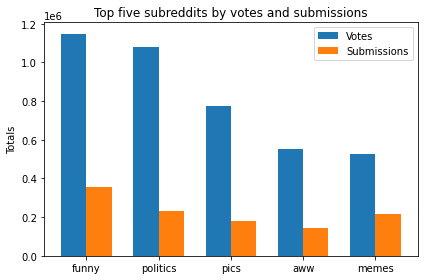

In [3]:
# Generate a bar graph of the top five subreddits.

bar_width = 0.35

import matplotlib
import matplotlib.pyplot as pyplot
import numpy

x = numpy.arange(len(subreddit_labels))

bar_graph, axes = pyplot.subplots()
vote_rectangles = axes.bar(x - bar_width/2, votes, bar_width, label='Votes')
submission_rectangles = axes.bar(x + bar_width/2, submissions, bar_width, label='Submissions')

axes.set_ylabel('Totals')
axes.set_title('Top five subreddits by votes and submissions')
axes.set_xticks(x)
axes.set_xticklabels(subreddit_labels)
axes.legend()

bar_graph.tight_layout()

In [1]:
import pandas as pd
import numpy as np

In [12]:
# Return a dataframe whose rows are the subreddits in the data set, with a 
# column for the subreddit name, upvotes, downvotes, and total votes. The test 
# argument can be used to filter rows of the data set by the indicated criteron.
def vote_totals(test=lambda x: True, chunk_size=100000):
    reader = pd.read_csv('./data/44_million_votes.txt', sep='\t', chunksize=chunk_size)
    
    column_names = ['SUBREDDIT', 'UPVOTES', 'DOWNVOTES', 'VOTES']
    subreddit_frame = pd.DataFrame(columns = column_names)
    
    r=0
    first_iteration = True
    for chunk in reader:
        boolean_series_up = chunk.apply(lambda x: test(x) and x['VOTE']=='upvote', axis=1)
        boolean_series_down = chunk.apply(lambda x: test(x) and x['VOTE']=='downvote', axis=1)
        filtered_chunk_up = chunk[boolean_series_up]
        filtered_chunk_down = chunk[boolean_series_down]
        if first_iteration:
            upvote_counter = filtered_chunk_up['SUBREDDIT'].value_counts()
            downvote_counter = filtered_chunk_down['SUBREDDIT'].value_counts()
            first_iteration = False
            r+=1
            print(r, 'chunks processed.')
        else:
            upvote_counter = upvote_counter.add(filtered_chunk_up['SUBREDDIT'].value_counts(), fill_value=0)
            downvote_counter = downvote_counter.add(filtered_chunk_down['SUBREDDIT'].value_counts(), fill_value=0)
            r+=1
            print(r, 'chunks processed.')
    
    counter = upvote_counter.add(downvote_counter, fill_value = 0)
    df = pd.concat([upvote_counter.rename('UPVOTES'), downvote_counter.rename('DOWNVOTES'), counter.rename('TOTAL_VOTES')], axis=1)
    df = df.fillna(0)
            
    return df

In [5]:
# Return a set consisting of the entries in a particular column of a CSV. The
# rows can be filtered by a test condition.
def get_column_as_set(filename, column_name, test=lambda x: True, chunk_size=10000000):
    reader = pd.read_csv(filename, sep='\t', chunksize=chunk_size)
    output_set = set()
    
    for chunk in reader:
        boolean_series = chunk.apply(test, axis=1)
        filtered_chunk = chunk[boolean_series]
        output_set = set(filtered_chunk[column_name]).union(output_set)
        
    return output_set

In [7]:
# Obtain set of users who only browse r/fountainpens.
fp_redditors = get_column_as_set('./data/44_million_votes.txt', 'USERNAME', test=lambda x: True if x['SUBREDDIT'] == 'r/fountainpens' else False)

In [13]:
# Tabulate voting data from r/fountainpen users.
fp_votes = vote_totals(lambda x: x['USERNAME'] in fp_redditors)

1 chunks processed.
2 chunks processed.
3 chunks processed.
4 chunks processed.
5 chunks processed.
6 chunks processed.
7 chunks processed.
8 chunks processed.
9 chunks processed.
10 chunks processed.
11 chunks processed.
12 chunks processed.
13 chunks processed.
14 chunks processed.
15 chunks processed.
16 chunks processed.
17 chunks processed.
18 chunks processed.
19 chunks processed.
20 chunks processed.
21 chunks processed.
22 chunks processed.
23 chunks processed.
24 chunks processed.
25 chunks processed.
26 chunks processed.
27 chunks processed.
28 chunks processed.
29 chunks processed.
30 chunks processed.
31 chunks processed.
32 chunks processed.
33 chunks processed.
34 chunks processed.
35 chunks processed.
36 chunks processed.
37 chunks processed.
38 chunks processed.
39 chunks processed.
40 chunks processed.
41 chunks processed.
42 chunks processed.
43 chunks processed.
44 chunks processed.
45 chunks processed.
46 chunks processed.
47 chunks processed.
48 chunks processed.
4

379 chunks processed.
380 chunks processed.
381 chunks processed.
382 chunks processed.
383 chunks processed.
384 chunks processed.
385 chunks processed.
386 chunks processed.
387 chunks processed.
388 chunks processed.
389 chunks processed.
390 chunks processed.
391 chunks processed.
392 chunks processed.
393 chunks processed.
394 chunks processed.
395 chunks processed.
396 chunks processed.
397 chunks processed.
398 chunks processed.
399 chunks processed.
400 chunks processed.
401 chunks processed.
402 chunks processed.
403 chunks processed.
404 chunks processed.
405 chunks processed.
406 chunks processed.
407 chunks processed.
408 chunks processed.
409 chunks processed.
410 chunks processed.
411 chunks processed.
412 chunks processed.
413 chunks processed.
414 chunks processed.
415 chunks processed.
416 chunks processed.
417 chunks processed.
418 chunks processed.
419 chunks processed.
420 chunks processed.
421 chunks processed.
422 chunks processed.
423 chunks processed.
424 chunks

In [15]:
# Tabulate all votes.
all_votes = vote_totals()

1 chunks processed.
2 chunks processed.
3 chunks processed.
4 chunks processed.
5 chunks processed.
6 chunks processed.
7 chunks processed.
8 chunks processed.
9 chunks processed.
10 chunks processed.
11 chunks processed.
12 chunks processed.
13 chunks processed.
14 chunks processed.
15 chunks processed.
16 chunks processed.
17 chunks processed.
18 chunks processed.
19 chunks processed.
20 chunks processed.
21 chunks processed.
22 chunks processed.
23 chunks processed.
24 chunks processed.
25 chunks processed.
26 chunks processed.
27 chunks processed.
28 chunks processed.
29 chunks processed.
30 chunks processed.
31 chunks processed.
32 chunks processed.
33 chunks processed.
34 chunks processed.
35 chunks processed.
36 chunks processed.
37 chunks processed.
38 chunks processed.
39 chunks processed.
40 chunks processed.
41 chunks processed.
42 chunks processed.
43 chunks processed.
44 chunks processed.
45 chunks processed.
46 chunks processed.
47 chunks processed.
48 chunks processed.
4

379 chunks processed.
380 chunks processed.
381 chunks processed.
382 chunks processed.
383 chunks processed.
384 chunks processed.
385 chunks processed.
386 chunks processed.
387 chunks processed.
388 chunks processed.
389 chunks processed.
390 chunks processed.
391 chunks processed.
392 chunks processed.
393 chunks processed.
394 chunks processed.
395 chunks processed.
396 chunks processed.
397 chunks processed.
398 chunks processed.
399 chunks processed.
400 chunks processed.
401 chunks processed.
402 chunks processed.
403 chunks processed.
404 chunks processed.
405 chunks processed.
406 chunks processed.
407 chunks processed.
408 chunks processed.
409 chunks processed.
410 chunks processed.
411 chunks processed.
412 chunks processed.
413 chunks processed.
414 chunks processed.
415 chunks processed.
416 chunks processed.
417 chunks processed.
418 chunks processed.
419 chunks processed.
420 chunks processed.
421 chunks processed.
422 chunks processed.
423 chunks processed.
424 chunks

In [50]:
# Concatenate the above data; only include subreddits with votes from r/fountainpens.
summary_df = pd.concat([fp_votes, all_votes.rename(columns={'UPVOTES':'ALL_UPVOTES', 'DOWNVOTES':'ALL_DOWNVOTES', 'TOTAL_VOTES':'ALL_TOTAL_VOTES'})], axis=1).dropna()

In [52]:
# Compute relative popularities for r/fountainpens and add them to the dataframe.
relative_popularity = summary_df.apply(lambda x: x['TOTAL_VOTES']/fp_votes['TOTAL_VOTES'].sum()-x['ALL_TOTAL_VOTES']/all_votes['TOTAL_VOTES'].sum(), axis=1)
relative_popularity = relative_popularity.rename('RELATIVE_POPULARITY')
summary_df = pd.concat([summary_df, relative_popularity], axis=1)

,UPVOTES,DOWNVOTES,TOTAL_VOTES,ALL_UPVOTES,ALL_DOWNVOTES,ALL_TOTAL_VOTES,RELATIVE_POPULARITY
r/0b0t,6.0,2.0,8.0,7.0,3.0,10.0,0.000011
r/0to100,1.0,0.0,1.0,3.0,0.0,3.0,0.000001
r/1000ccplus,4.0,0.0,4.0,1016.0,59.0,1075.0,-0.000018
r/100yearsago,14.0,0.0,14.0,651.0,62.0,713.0,0.000003
r/1022,53.0,0.0,53.0,178.0,40.0,218.0,0.000068
...,...,...,...,...,...,...,...
u/vredditshare,0.0,1.0,1.0,0.0,1.0,1.0,0.000001
u/webhostingservicee,0.0,2.0,2.0,0.0,2.0,2.0,0.000003
u/well_hello2u,0.0,1.0,1.0,0.0,1.0,1.0,0.000001
u/wynterRose1998,0.0,1.0,1.0,0.0,1.0,1.0,0.000001


In [54]:
# Sort the data frame.
summary_df = summary_df.sort_values(['RELATIVE_POPULARITY', 'ALL_TOTAL_VOTES'], ascending=False)

In [55]:
# Write results to CSV.
summary_df.to_csv(path_or_buf='./data/relative_popularity_r-fountainpens.csv')